In [1]:
from fastai.vision.utils import untar_data, URLs
# PASCAL dataset can have more than one label per image
path = untar_data(URLs.PASCAL_2007)

In [2]:
import pandas as pd

# uses CVS file to get the labels per image as opposed to file name and folder
# structure as conventions as previous single label datasets
# TODO : Is it possible to manage multiple labels per image with file/folder?
# Answer : Likely not worth it, since explicity CSV list is easy to check vs
# super fancy naming convention (experience from managing Pokemon assets lol)
df = pd.read_csv(path/'train.csv')
# inspect the CVS file by reading it into a Pandas DataFrame
# output shows that a list of categories in each image is shown as a space
# separated string
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [3]:
# PANDAS and DATAFRAMES
# Pandas is a Python library to edit and analyze tabular and time series data
# DataFrames are a table of rows and columns : the main data structure in Pandas

# Trailing :s are optional (in numpy, pytorch, pandas, etc)
# so both of these first row variants work
# first_row = df.iloc[0,:]
first_row = df.iloc[0]
first_column = df.iloc[:, 0]
print(f'--[first_row]--\n{first_row}\n--[first_column]--\n{first_column}')

# can also index by column name
fname_column = df['fname']
#print(f'--[fname_column]--\n{fname_column}')


--[first_row]--
fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object
--[first_column]--
0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object


In [4]:
from fastai.vision.data import DataBlock

# Create new columns and use them to do calculations
df1 = pd.DataFrame()
df1['a'] = [1,2,3, 4]
df1['b'] = [10, 20, 30, 40]
sum_column = df1['a'] + df1['b']
print(f'--[a_column]--\n{df1["a"]}\n--[b_column]--\n{df1["b"]}\n--[sum_column]--\n{sum_column}')


dblock = DataBlock()
dsets = dblock.datasets(df1)
dsets.train[0]
# TODO : Why isn't there a valid set? Set up one
#dsets.valid[0]

--[a_column]--
0    1
1    2
2    3
3    4
Name: a, dtype: int64
--[b_column]--
0    10
1    20
2    30
3    40
Name: b, dtype: int64
--[sum_column]--
0    11
1    22
2    33
3    44
dtype: int64


(a     4
 b    40
 Name: 3, dtype: int64,
 a     4
 b    40
 Name: 3, dtype: int64)

In [5]:
dblock = DataBlock()
dsets = dblock.datasets(df)

# a row of the DataFrame is returned TWICE ... once for the image and once for
# the label ... because the DataBlock assumes we have :
# - input
# - target
print(f'--[train]--\n{dsets.train[0]}\n--[valid]--\n{dsets.valid[0]}')


--[train]--
(fname       000774.jpg
labels           train
is_valid         False
Name: 377, dtype: object, fname       000774.jpg
labels           train
is_valid         False
Name: 377, dtype: object)
--[valid]--
(fname            002873.jpg
labels      aeroplane sheep
is_valid              False
Name: 1441, dtype: object, fname            002873.jpg
labels      aeroplane sheep
is_valid              False
Name: 1441, dtype: object)


In [6]:
# We will need to capture explicitly from the DataFrame :
# - 'fname' the image file name
def get_image_path(row):
    #return row['fname']
    # we actually need the path name to open the image
    return path/'train'/row['fname']
# - 'labels' the list of labels
def get_labels(row):
    #return row['labels']
    # we actually need to split the labels on spaces
    return row['labels'].split(' ')

dblock=DataBlock(get_x=get_image_path, get_y=get_labels)
dsets=dblock.datasets(df)

print(f'--[train]--\n{dsets.train[0]}\n--[valid]--\n{dsets.valid[0]}')

--[train]--
(Path('/Users/mton/.fastai/data/pascal_2007/train/004257.jpg'), ['person', 'chair'])
--[valid]--
(Path('/Users/mton/.fastai/data/pascal_2007/train/004897.jpg'), ['person'])


In [7]:
# lambda is a keyword shortcut for defining an anonymous function inline
# however they aren't compatible with serialization (saving and loading)
# i.e. if you want to export your Learner after training you can't use lambda
# Lambda are not serializable because:
# - they are anonymous and not bound to a name or object in memory
# - lambda functions are also stateless and have no environment/context ...
#   storing and retrieving the state of a lambda function is not possible
'''
dblock = DataBlock(get_x=lambda r:r['fname'], get_y=lambda r:r['labels'])
dsets = dblock.datasets(df)
'''

"\ndblock = DataBlock(get_x=lambda r:r['fname'], get_y=lambda r:r['labels'])\ndsets = dblock.datasets(df)\n"

In [8]:
from fastai.vision.data import ImageBlock, MultiCategoryBlock

# actually open the images and convert to tensors
dblock = DataBlock(
    # ImageBlock works fine because we have a file path
    # But... MultiCategoryBlock is needed because we have multiple labels
    blocks=(ImageBlock, MultiCategoryBlock), # type:ignore
    get_x=get_image_path,
    get_y=get_labels)

dsets = dblock.datasets(df)
# unlike with CategoryBlock where a single int is returned, 
# MultiCategoryBlock returns a list of labels
# We have a list of 0s, with a 1 where a category is present
# TODO : What is one-hot encoding?
# Answer : https://en.wikipedia.org/wiki/One-hot
# In digital circuits and machine learning, a one-hot is a group of bits among 
# which the legal combinations of values are only those with a 
# single high (1) bit and all the others low (0).[1] A similar implementation 
# in which all bits are '1' except one '0' is sometimes called one-cold
# TODO : How is the list of 0s and 1s created?  How is the length determined?
# Pytorch requires tensors, and everything has to be the same size/length

print(f'--[train]--\n{dsets.train[0]}\n--[valid]--\n{dsets.valid[0]}')
print(f'--[train {len(dsets.train.vocab)}]--\n{dsets.train.vocab}\n--[valid {len(dsets.valid.vocab)}]--\n{dsets.valid.vocab}')

--[train]--
(PILImage mode=RGB size=500x375, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 1.]))
--[valid]--
(PILImage mode=RGB size=500x374, TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                     0., 0., 0., 0., 1.]))
--[train 20]--
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
--[valid 20]--
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [9]:
import torch

idxs = torch.where(dsets.train[0][1]==1.0)[0] # type: ignore
dsets.train.vocab[idxs]

(#1) ['tvmonitor']

In [10]:
def splitter(dataformat):
    train = dataformat.index[~dataformat['is_valid']].tolist()
    valid = dataformat.index[dataformat['is_valid']].tolist()
    return train, valid

dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock), # type:ignore
    # do the split manually
    splitter = splitter,
    get_x = get_image_path,
    get_y = get_labels
)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [11]:
from fastai.vision.augment import RandomResizedCrop

dblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock), # type:ignore
    splitter = splitter,
    get_x = get_image_path,
    get_y = get_labels,
    # ensure every image is the same size
    item_tfms = RandomResizedCrop(128, min_scale=0.35) # type:ignore
)

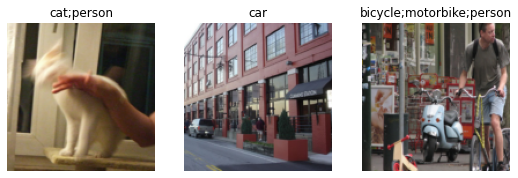

In [12]:
dls = dblock.dataloaders(df)
# TODO : If anything goes wrong use "summary" method from previous lesson : HOW?
dls.show_batch(nrows=1, ncols=3)

In [13]:
from fastai.vision.learner import vision_learner
from fastai.vision.models import resnet18

# Chapter 4 showed that a learner needs 4 main things :
# - model : we'll leverage fastai's resnet18, class inheriting from nn.Module
# - optimizer : fastai will use SGD by default
# - DatLoaders object
# - loss function ... let's FOCUS on ensuring we have a suitable loss function
learn = vision_learner(dls, resnet18)

/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mton/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
x,y = dls.train.one_batch()
activs = learn.model(x)
# TODO : why does activs have a shape of batch_size 64 and prob of 20 categories??
print(f'--[activs.shape]--(batch [64], categories [20])--\n{activs.shape}\n--[model activations]--(activs[0])--\n{activs[0]}')

--[activs.shape]--(batch [64], categories [20])--
torch.Size([64, 20])
--[model activations]--(activs[0])--
TensorBase([ 0.4489, -0.4512,  0.0557, -1.1469, -0.3247, -3.9617, -0.2041,
            -0.1095, -0.0368, -0.1866,  0.4068, -2.3593,  2.0482,  1.5040,
             2.1923,  3.4263,  2.3219, -0.1104,  3.2407, -0.3006],
           grad_fn=<AliasBackward0>)
